# H&M EDA

- Transactions analysis:
    - Q1 - Which are the TOP 100 articles in terms of sold quantity?
    - Q2 - Are there articles that have been sold only once?
    - Q3 - Which are the TOP 100 articles that generated most earnings for the company?
    - Q4 - Which are articles that generated lower earnings for the company? 

- Customer Analysis:
    - Q5 - Which age group purchase more articles?
    - Q6 - Which age group generates more earnings for the company?
    - Q7 - Do active customers on the fashion news purchase more articles?
    - Q8 - Does the club member status influence the purchased quantity of articles?

## Import libraries

In [57]:
import numpy as np 
import pandas as pd
from pandasql import sqldf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


sns.despine()
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

<Figure size 640x480 with 0 Axes>

### Data import

First, we import the data.

In [58]:
df_a = pd.read_csv("data/articles.csv")
df_t = pd.read_csv("data/transactions_train.csv")
df_c = pd.read_csv("data/customers.csv")

### Articles dataframe analysis

In [59]:
df_a.head(1)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [60]:
df_a.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [61]:
print(f"The dataframe articles has {len(df_a)} rows")

The dataframe articles has 105542 rows


The "articles" dataframe has 25 columns and more than 100k rows.<br>
For our our analysis we will just select the following columns: 
- article_id
- prod_name
- product_type_name
- product_group_name
- colour_group_name
- index_name

By considering only these columns we can also save lots of memory.

To filter the columns, we will use SQL like code through SQL-DF library.

In [62]:
df_a = sqldf("""SELECT article_id, prod_name, product_type_name, product_group_name, colour_group_name, index_name
            FROM df_a
            """)

In [63]:
df_a.head()

,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,108775015,Strap top,Vest top,Garment Upper body,Black,Ladieswear
1,108775044,Strap top,Vest top,Garment Upper body,White,Ladieswear
2,108775051,Strap top (1),Vest top,Garment Upper body,Off White,Ladieswear
3,110065001,OP T-shirt (Idro),Bra,Underwear,Black,Lingeries/Tights
4,110065002,OP T-shirt (Idro),Bra,Underwear,White,Lingeries/Tights


### Transactions dataframe analysis

In [64]:
df_t.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2


In [65]:
df_t.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [66]:
print(f"The dataframe Transactions has {len(df_t)} rows")

The dataframe Transactions has 31788324 rows


The Transactions dataframe has more than 31 million rows: in order to save memory, we decide to drop some columns and keep only "customer_id", "article_id", "price".

In [67]:
df_t = df_t[["customer_id", "article_id", "price"]]

In the following we will focus in the analysis of the transaction dataframe, in order to discover the most and least sold products.

# Transactions analysis 

First, we extract the quantities sold per article using the value counts method on the "article_id" column of the transaction dataframe.

In [68]:
df_sold_qty = df_t["article_id"].value_counts()
df_sold_qty

article_id
706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
902723001        1
896148001        1
873278006        1
905254011        1
881049002        1
Name: count, Length: 104547, dtype: int64

**Then we create a dataframe based on this pandas series: this is necessary since later this dataframe will be joined with the "article" dataframe by the article_id column, in order to get informtions on the products.**

In [69]:
df_sold_qty=df_sold_qty.reset_index()
df_sold_qty.set_index("article_id", inplace=True)
df_sold_qty.rename(columns = {"count":"sold_qty"}, inplace=True)
df_sold_qty.head()

,sold_qty
article_id,
706016001,50287
706016002,35043
372860001,31718
610776002,30199
759871002,26329


Then we can get some summary statistics about the sold quantities by calling the describe method on the "sold_qty" column:

In [70]:
df_sold_qty["sold_qty"].describe()

count    104547.000000
mean        304.057735
std         791.266060
min           1.000000
25%          14.000000
50%          65.000000
75%         286.000000
max       50287.000000
Name: sold_qty, dtype: float64

Summary statistics on the sold quantities:
- there are 105000 different articles in the transactions.
- There are items which have been sold only once
- 25% of sold products, have been sold 14 or less times
- 50% were sold 65 or less times
- 75% were sold 286 or less times,
- The most sold item have been sold 50287 times.

**We can expect a very skewed distribution of this variable, which can be checked by plotting the variable:**

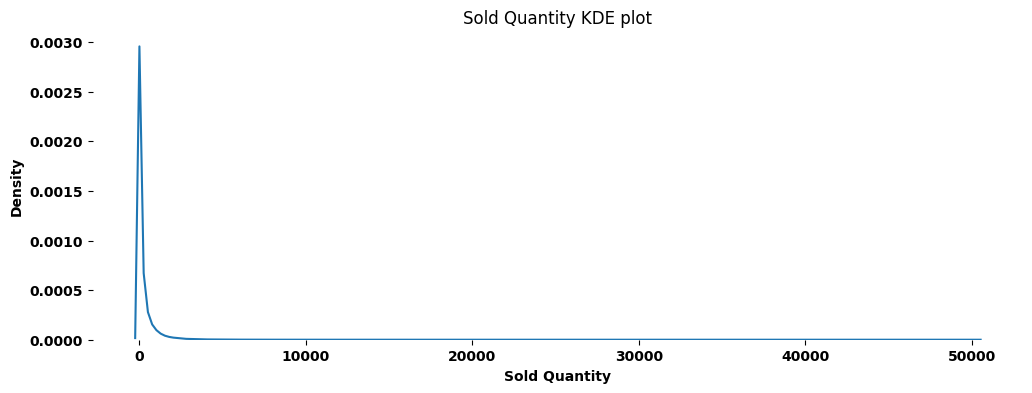

In [71]:
plt.figure(figsize=(12,4))
plt.title("Sold Quantity KDE plot")
sns.kdeplot(df_sold_qty["sold_qty"])
plt.xlabel("Sold Quantity")
plt.show()

**Indeed, the distribution is heavily right skewed.**

It could be also interesting to check high quantiles of the distribution.

In [72]:
df_sold_qty["sold_qty"].quantile([0.90,0.95,0.99,0.999])

0.900     793.000
0.950    1318.000
0.990    3185.080
0.999    9282.534
Name: sold_qty, dtype: float64

The quantile analysis can give us the following insights: 
- 90% of the articles have been sold 793 or less times
- 95% of the articles have been sold 1318 or less times
- 99% of the articles have been sold 3185 or less times

**This shows that there is a very small minority of items that sold more than 10k times (just the 0.001%), highlighting the skewness nature of the distribution.**

# Q1 - Which are the TOP 100 articles in terms of sold quantity?

We can simply extract the most 100 sold items from the dataframe "df_sold_qty" by taking the first 100 rows.

In [73]:
top_100_sold = df_sold_qty.iloc[:100]
top_100_sold.head()

,sold_qty
article_id,
706016001,50287
706016002,35043
372860001,31718
610776002,30199
759871002,26329


Then we join this dataframe with the articles dataframe (df_a) by the "article_id" column in order to get more details about each article.

In [74]:
top_100_details = sqldf("""SELECT *
        FROM top_100_sold t
        INNER JOIN df_a a
        on t.article_id = a.article_id
    """)

In [75]:
top_100_details.head()

,article_id,sold_qty,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,108775015,10841,108775015,Strap top,Vest top,Garment Upper body,Black,Ladieswear
1,111586001,14191,111586001,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Black,Lingeries/Tights
2,111593001,13888,111593001,Support 40 den 1p Tights,Underwear Tights,Socks & Tights,Black,Lingeries/Tights
3,156231001,21013,156231001,Box 4p Tights,Underwear Tights,Socks & Tights,Black,Lingeries/Tights
4,158340001,16533,158340001,Highwaist 30 den 1p Tights,Leggings/Tights,Garment Lower body,Black,Lingeries/Tights


C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3559498765.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="prod_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("prod_name")["sold_qty"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3559498765.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="prod_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("prod_name")["sold_qty"].sum() \


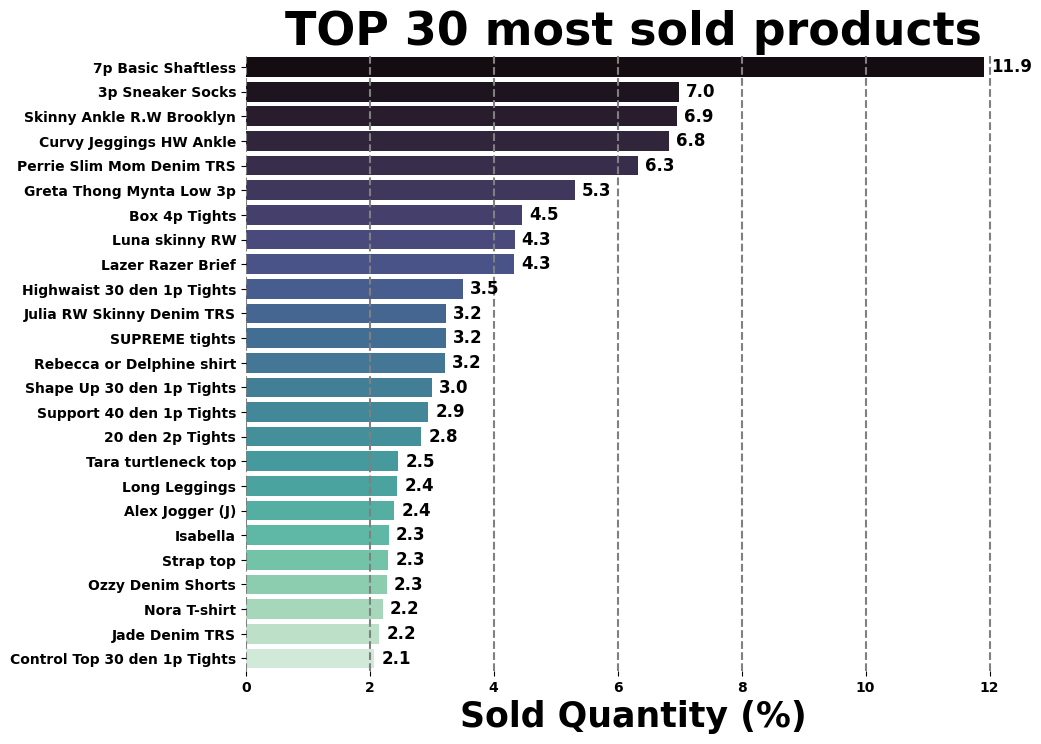

In [76]:
plt.figure(figsize=(10,8))
plt.title("TOP 30 most sold products", fontsize=33, fontweight="bold")
no=30
g = sns.barplot(y="prod_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("prod_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=12)
plt.xlabel("Sold Quantity (%)", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

We decided to plot only the TOP 30 of articles since including the TOP 50 or 100 product names would hve lead to a very big plot !
Indeed we can see that among the TOP 100 sold articles:
- The trousers "Jade HW Skinny Denim TRS " is responsible for almost 19% of all sold products.
- the TOP 4 of most sold items, is responsible for almost 40% of the TOP 100 sold products.

For what concerns other product characteristics (besides the product name), we can obtain very effective plots even if we consider 100 products:

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3103279269.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3103279269.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3103279269.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="index_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("index_name")["sold_qty"].sum() \
C:\Users\vietd

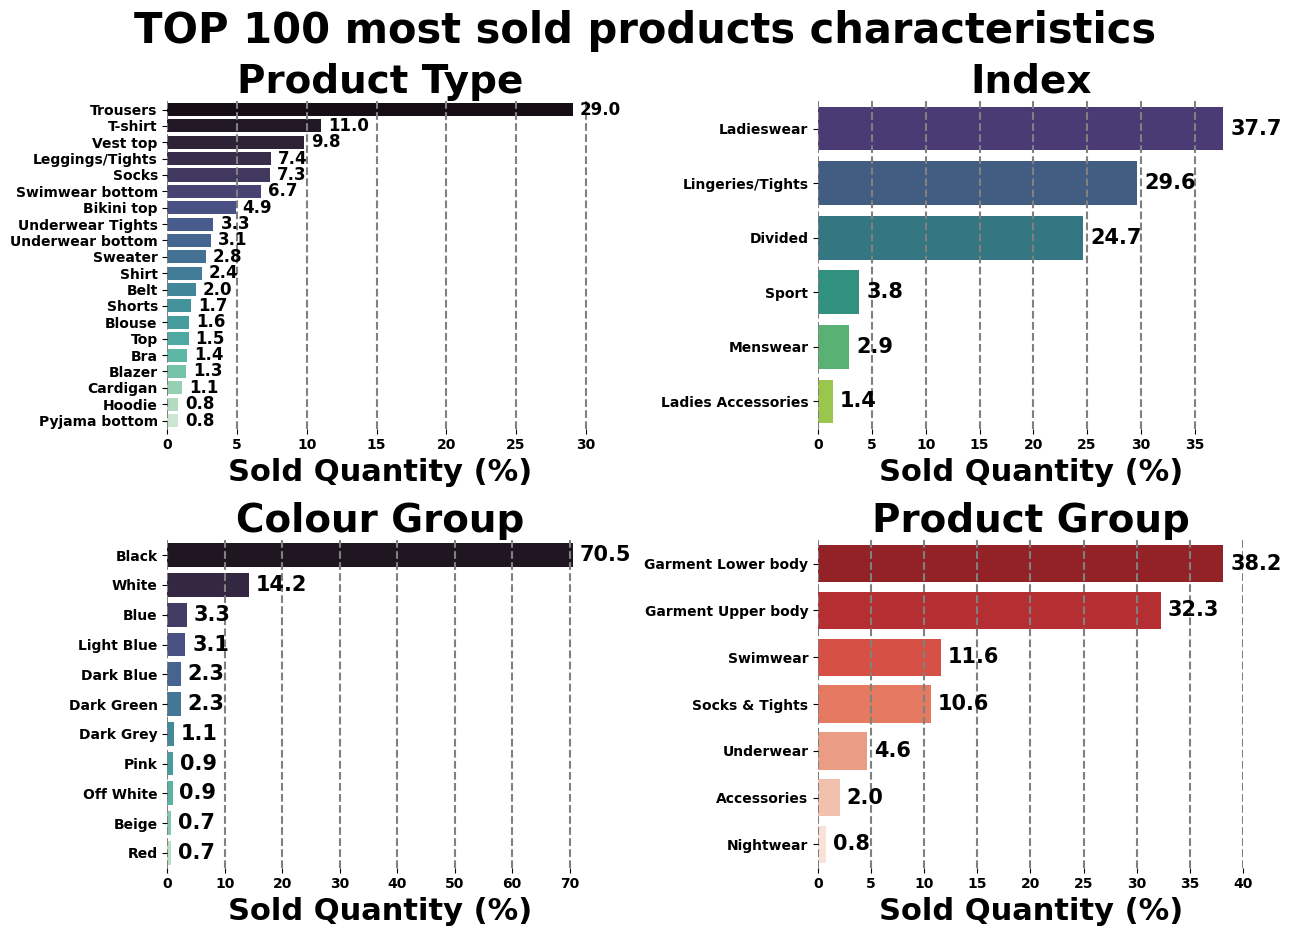

In [77]:
fig, ax = plt.subplots(2,2, figsize=(13,9.5))
plt.suptitle("TOP 100 most sold products characteristics", fontweight="bold",fontsize=30)

no=100

g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[0,0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=12, color="black")
ax[0,0].set_ylabel("")
ax[0,0].set_xlabel("Sold Quantity (%)", size=22, fontweight="bold")
ax[0,0].set_title("Product Type",fontweight="bold",fontsize=28)
ax[0,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="index_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("index_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[0,1],palette="viridis", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15, color="black")
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("Sold Quantity (%)", size=22, fontweight="bold")
ax[0,1].set_title("Index",fontweight="bold",fontsize=28)
ax[0,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="colour_group_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("colour_group_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[1,0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15, color="black")
ax[1,0].set_ylabel("")
ax[1,0].set_xlabel("Sold Quantity (%)", size=22, fontweight="bold")
ax[1,0].set_title("Colour Group",fontweight="bold",fontsize=28)
ax[1,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="product_group_name", x="sold_qty(%)", data=top_100_details.iloc[:no].groupby("product_group_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[1,1],palette="Reds_r", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15, color="black")
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("Sold Quantity (%)", size=22, fontweight="bold")
ax[1,1].set_title("Product Group",fontweight="bold",fontsize=28)
ax[1,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
fig.tight_layout()

plt.show() 

Among the TOP 100 of solds products:
- Almost 30% of sold products are trousers
- 38% is Ladieswear
- 30% is Lingeries/Tights
- Over 70% are black colored
- Almost 40% are related to lower body

# Q2 - Are there articles that have been sold only once?

As we observed in the previous analysis, there are items that sold only once. We will investigate about these products.

In [78]:
df_sold_qty["sold_qty"].where(lambda x: x==1).dropna() #top 15% products

article_id
533261032    1.0
760195006    1.0
895610008    1.0
866731007    1.0
902358003    1.0
            ... 
902723001    1.0
896148001    1.0
873278006    1.0
905254011    1.0
881049002    1.0
Name: sold_qty, Length: 4491, dtype: float64

**Almost 5000 different items have been sold just once. <br>
Since in the "Transactions" dataframe there are around 100000 different items, this means that among the transactions, almost 5% of the products  have only been sold once.**

Then we can extract these items from the "df_sold_qty" dataframe by taking the last 4491 values. ( There are 4491 items that sold once)

In [79]:
worst_sold = df_sold_qty.tail(4491)

And finally join this newly defined dataframe "worst_sold" to the articles dataframe df_a to get the articles characterisics.

In [80]:
worst_details = sqldf("""SELECT *
        FROM worst_sold t
        INNER JOIN df_a a
        on t.article_id = a.article_id
    """)

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\1704781047.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\1704781047.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\1704781047.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="index_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("index_name")["sold_qty"].sum() \
C:\Users\vietd\AppDa

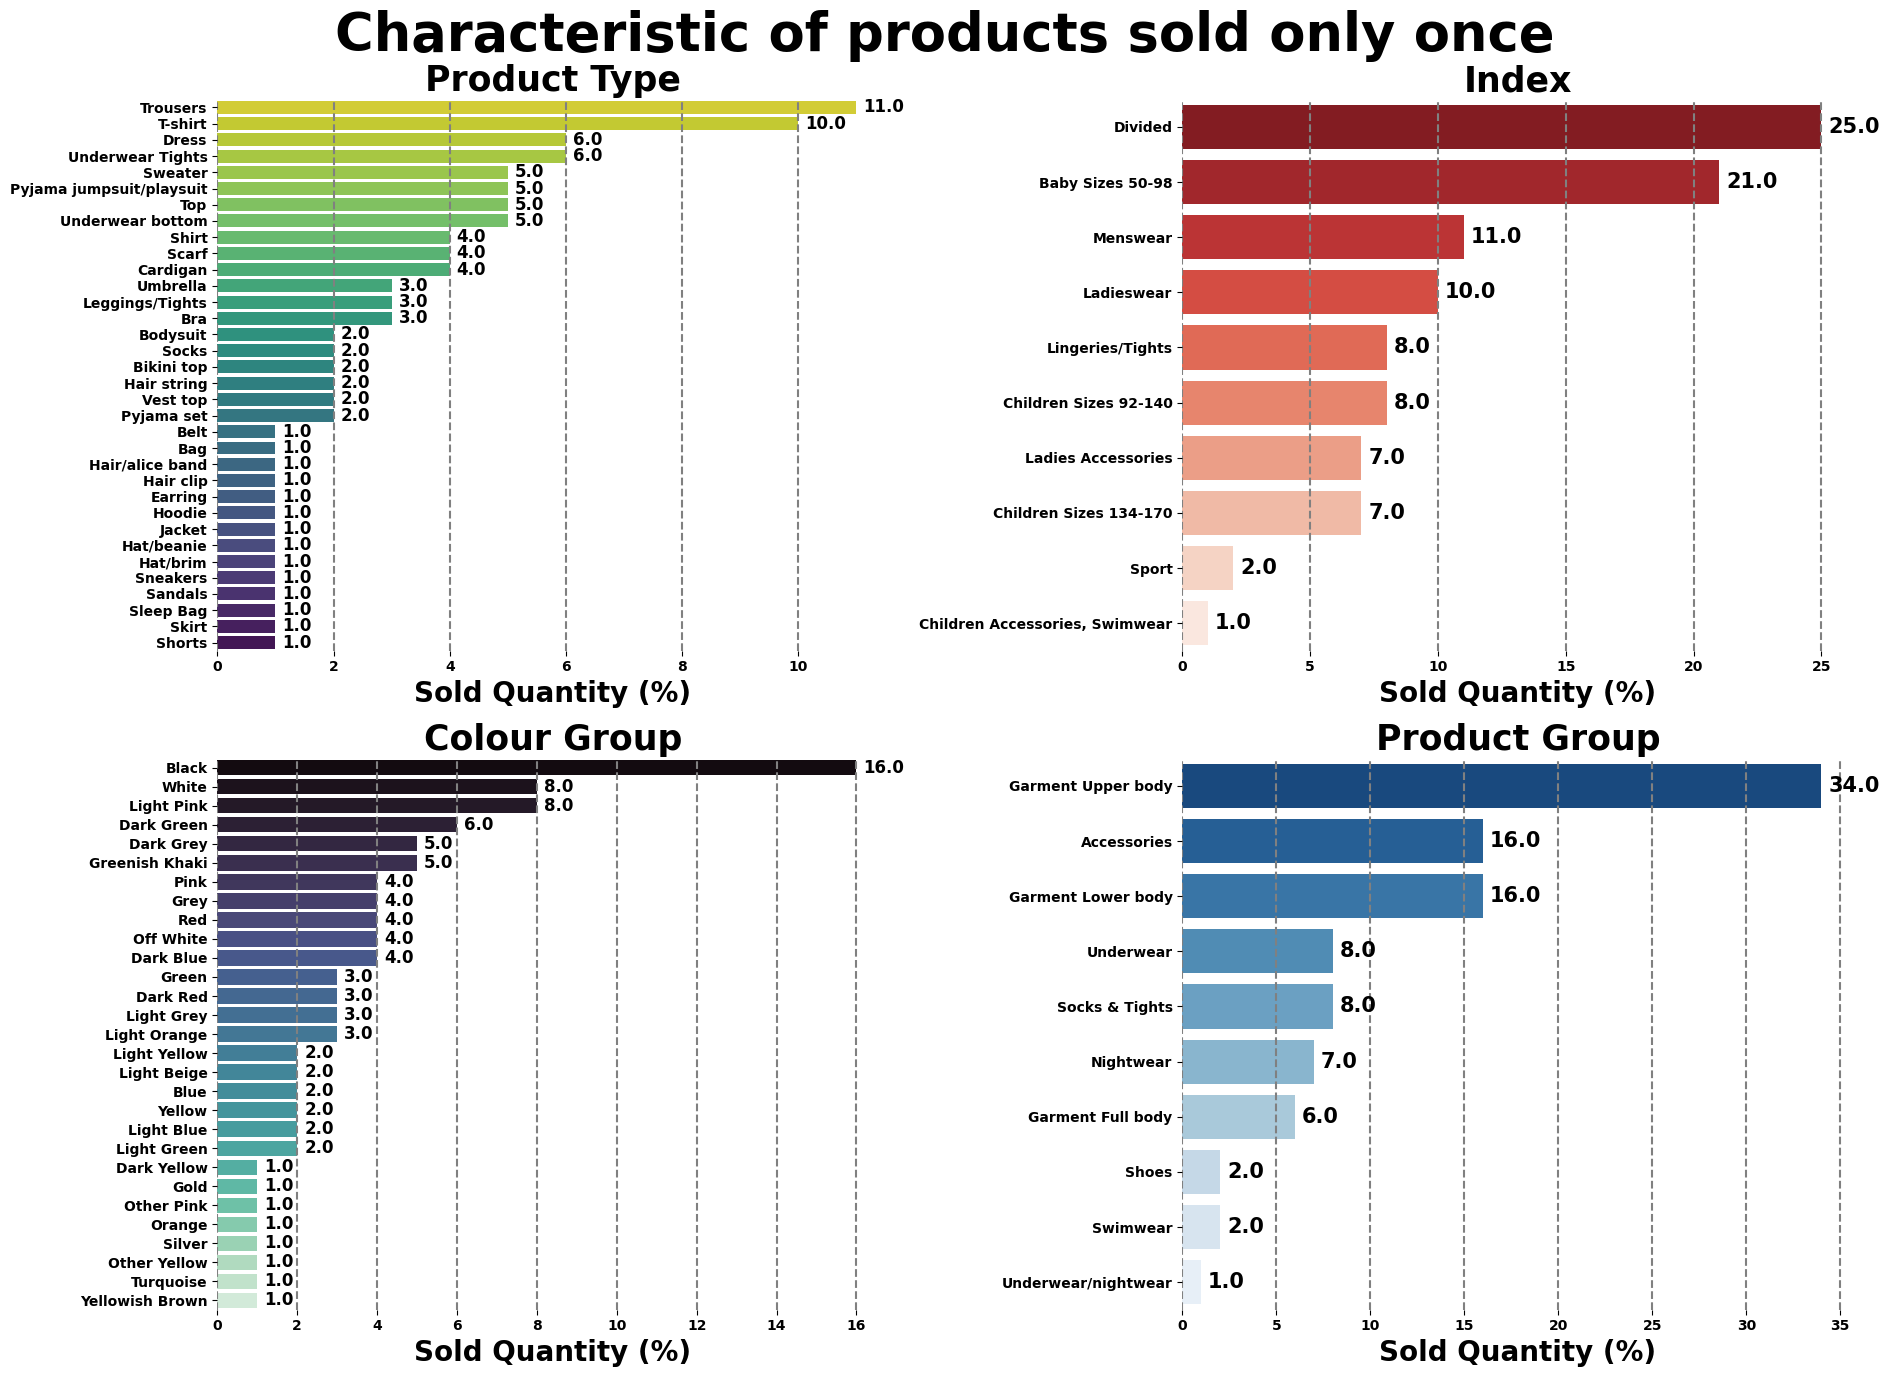

In [81]:
fig, ax = plt.subplots(2,2, figsize=(19,14))
plt.suptitle("Characteristic of products sold only once", size=38, fontweight="bold")

no=100

g = sns.barplot(y="product_type_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("product_type_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[0,0],palette="viridis_r", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=12, color="black")
ax[0,0].set_ylabel("")
ax[0,0].set_xlabel("Sold Quantity (%)", size=20, fontweight="bold")
ax[0,0].set_title("Product Type", size=25, fontweight="bold")
ax[0,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="index_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("index_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[0,1],palette="Reds_r", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15, color="black")
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("Sold Quantity (%)", size=20, fontweight="bold")
ax[0,1].set_title("Index", size=25, fontweight="bold")
ax[0,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="colour_group_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("colour_group_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[1,0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=12, color="black")
ax[1,0].set_ylabel("")
ax[1,0].set_xlabel("Sold Quantity (%)", size=20, fontweight="bold")
ax[1,0].set_title("Colour Group", size=25, fontweight="bold")
ax[1,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="product_group_name", x="sold_qty(%)", data=worst_details.iloc[:no].groupby("product_group_name")["sold_qty"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('sold_qty(%)').reset_index().sort_values(by="sold_qty(%)", ascending=False), \
            ax=ax[1,1],palette="Blues_r", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15, color="black")
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("Sold Quantity (%)", size=20, fontweight="bold")
ax[1,1].set_title("Product Group", size=25, fontweight="bold")
ax[1,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

fig.tight_layout()

plt.show() 

Insights:
- We can see that almost 60% of only sold once items are for children.

# Q3 - Which are the TOP 100 articles that generated most earnings for the company?

After analyzing the sold quantites for each product, it can be interesting to analyze the total earnings generated by each product.<br>
**The earnings can be calculated by multiplying the price of each product by its total sold quanity**. <br>
*NOTE: For privacy reasons, the prices have been transformed/scaled by the creator of the dataset, and so do not represent any known currency.*

We will now create a new dataframe df_prices which will inlude the earnings generated by each product.

In [82]:
df_prices = df_t[["price","article_id"]].groupby("article_id").sum().sort_values(by="price", ascending=False)

In [83]:
df_prices.rename(columns={"price":"earning"}, inplace=True)
df_prices = df_prices.reset_index()

In [84]:
df_prices.head()

,article_id,earning
0,706016001,1631.732102
1,706016002,1136.321085
2,568601006,939.268593
3,448509014,781.478390
4,706016003,692.195915


**We can see that the most earnings generated by a product is 1631**. <br>
How much is the total earnings?

In [85]:
print("Number of different sold articles:",len(df_prices["earning"]))
print("Total Earnings:",df_prices["earning"].sum())

Number of different sold articles: 104547
Total Earnings: 884645.974050846


In [86]:
for i in [10,50,100,200,300,400,1000]:
    print("The TOP {} of products that generate most earnings, account for the {:.2f} % of total earnings".format(i, df_prices["earning"].iloc[:i].sum() / df_prices["earning"].iloc[:].sum() * 100) ) 

The TOP 10 of products that generate most earnings, account for the 0.94 % of total earnings
The TOP 50 of products that generate most earnings, account for the 2.74 % of total earnings
The TOP 100 of products that generate most earnings, account for the 4.36 % of total earnings
The TOP 200 of products that generate most earnings, account for the 6.75 % of total earnings
The TOP 300 of products that generate most earnings, account for the 8.60 % of total earnings
The TOP 400 of products that generate most earnings, account for the 10.20 % of total earnings
The TOP 1000 of products that generate most earnings, account for the 17.50 % of total earnings


**The TOP 100 of over 100000 products, generates around 5% of the total earnings. It can be interesting to check these products names and characteristics.**

So we create a new dataframe top_100_prices, where we include only the TOP 100 articles from the df_prices dataframe.

In [87]:
top_100_prices=df_prices.iloc[:100]

Then, as seen before, we join this new dataframe to the articles dataframe df_a to get the articles information.

In [88]:
top_100_price_details = sqldf("""SELECT *
        FROM top_100_prices t
        INNER JOIN df_a a
        on t.article_id = a.article_id""")

In [89]:
top_100_price_details.head()

,article_id,earning,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,706016001,1631.732102,706016001,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Black,Divided
1,706016002,1136.321085,706016002,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Light Blue,Divided
2,568601006,939.268593,568601006,Mariette Blazer,Blazer,Garment Upper body,Black,Ladieswear
3,448509014,781.478390,448509014,Perrie Slim Mom Denim TRS,Trousers,Garment Lower body,Blue,Divided
4,706016003,692.195915,706016003,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Dark Blue,Divided


C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2457706304.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="prod_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("prod_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2457706304.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="prod_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("prod_name")["earning"].sum() \


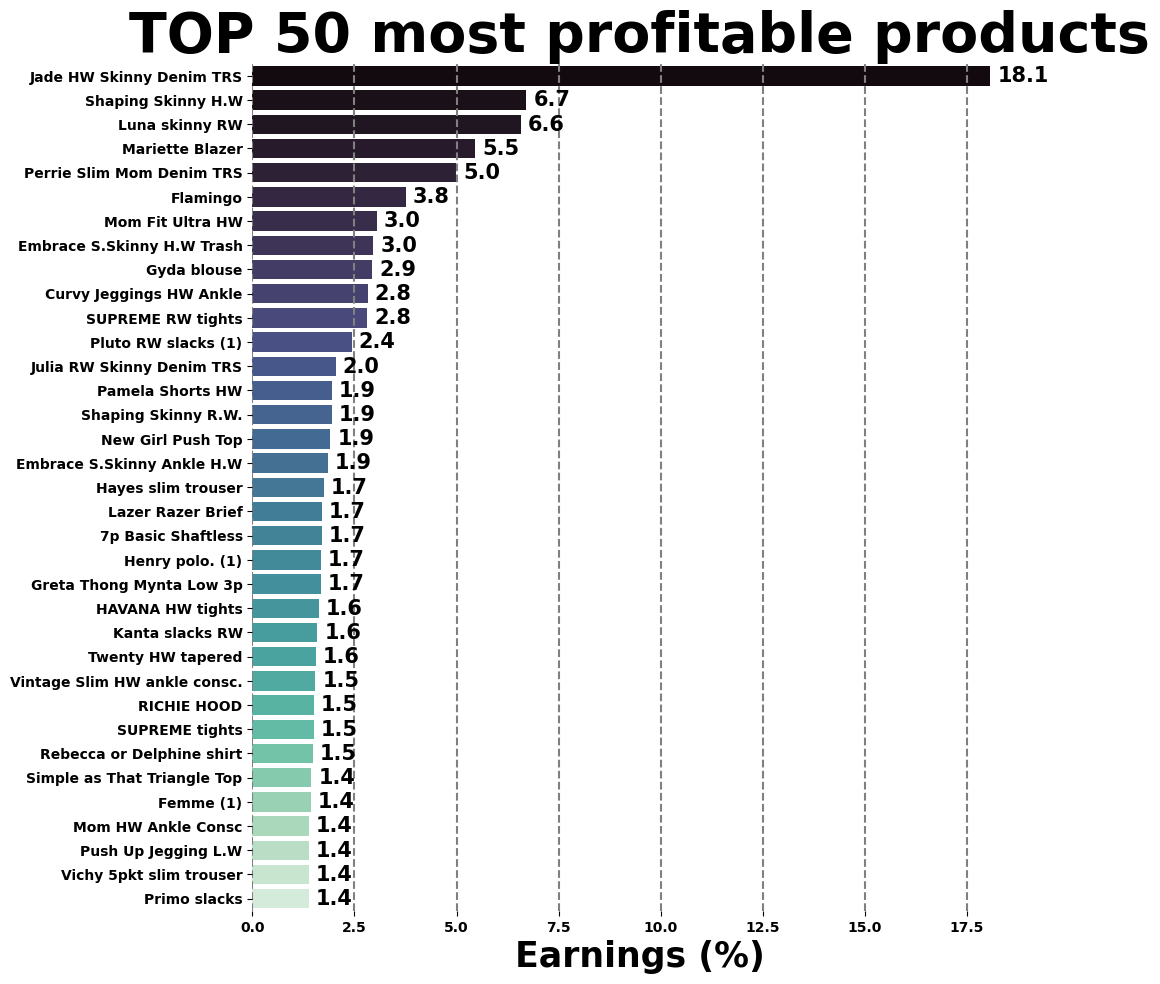

In [90]:
plt.figure(figsize=(10,11))
plt.title("TOP 50 most profitable products", size=40, fontweight="bold")
no=50
g = sns.barplot(y="prod_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("prod_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=15)
plt.xlabel("Earnings (%)", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\4262178453.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="product_type_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\4262178453.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="product_type_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\4262178453.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="index_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("index_name")["earning"].sum() \
C:

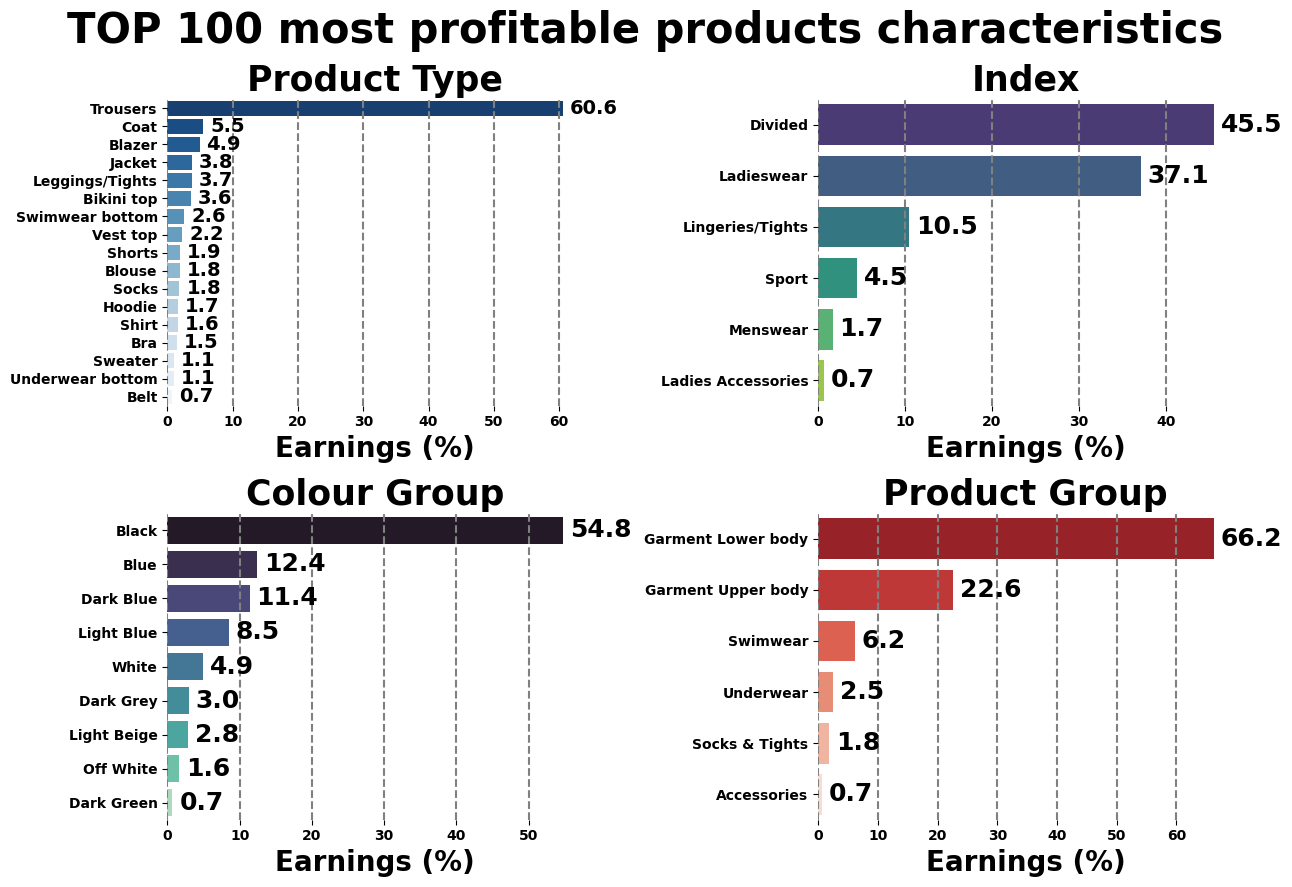

In [91]:
fig, ax = plt.subplots(2,2, figsize=(13,9))
plt.suptitle("TOP 100 most profitable products characteristics", fontweight="bold", fontsize=30)

no=100

g = sns.barplot(y="product_type_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[0,0],palette="Blues_r", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=14, color="black")
ax[0,0].set_ylabel("")
ax[0,0].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[0,0].set_title("Product Type", size=25,fontweight="bold")
ax[0,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)


g = sns.barplot(y="index_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("index_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[0,1],palette="viridis", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', padding = 5, fontsize=18, color="black")
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[0,1].set_title("Index", size=25,fontweight="bold")
ax[0,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)


g = sns.barplot(y="colour_group_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("colour_group_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[1,0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=18, color="black")
ax[1,0].set_ylabel("")
ax[1,0].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[1,0].set_title("Colour Group", size=25,fontweight="bold")
ax[1,0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)

g = sns.barplot(y="product_group_name", x="earning(%)", data=top_100_price_details.iloc[:no].groupby("product_group_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[1,1],palette="Reds_r", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', padding=5, fontsize=18, color="black")
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[1,1].set_title("Product Group", size=25,fontweight="bold")
ax[1,1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
fig.tight_layout()

plt.show() 

Insights:
- Over 60% of the TOP 100 products in terms of earnings are generated by selling trousers
- Around 50% of these products are divided (a H&M teenage collection)
- 37% of the products are from the Ladieswear line
- 55% of the products are black
- 66.2% of the products are related to lower body

**NOTE: It is also important to notice that the TOP 100 most profitable products list do not exactly match the TOP 100 most sold products one, since lots of products that sells a lot in quantity are cheap, and so generate less earnings.**

# Q4 - Which are articles that generated lower earnings for the company? 

After checking the most profitable products, it can be interesting to see which are the WORST 100 products in terms of earnings.

In [92]:
worst_100_prices=df_prices.iloc[-100:]

In [93]:
worst_100_price_details = sqldf("""SELECT *
        FROM worst_100_prices t
        INNER JOIN df_a a
        on t.article_id = a.article_id""")

In [94]:
worst_100_price_details.head()

,article_id,earning,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,555293002,0.002136,555293002,Elin thin hair elastic,Hair string,Accessories,Light Pink,Divided
1,502262002,0.002119,502262002,Kelly mittens,Gloves,Accessories,Light Grey,Baby Sizes 50-98
2,585716001,0.002034,585716001,Festival dress,Dress,Garment Full body,Light Orange,Children Sizes 134-170
3,807241091,0.001864,807241091,1p Fun Socks,Socks,Socks & Tights,Light Grey,Lingeries/Tights
4,549480005,0.001695,549480005,Hailey tee,T-shirt,Garment Upper body,Black,Divided


C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3926004633.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(x="product_type_name", y="earning(%)", data=worst_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3926004633.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="product_type_name", y="earning(%)", data=worst_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3926004633.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(g.get_xticklabels(), rotation=80)
C:\Users\vietd\AppData\Local\Temp\ipykerne

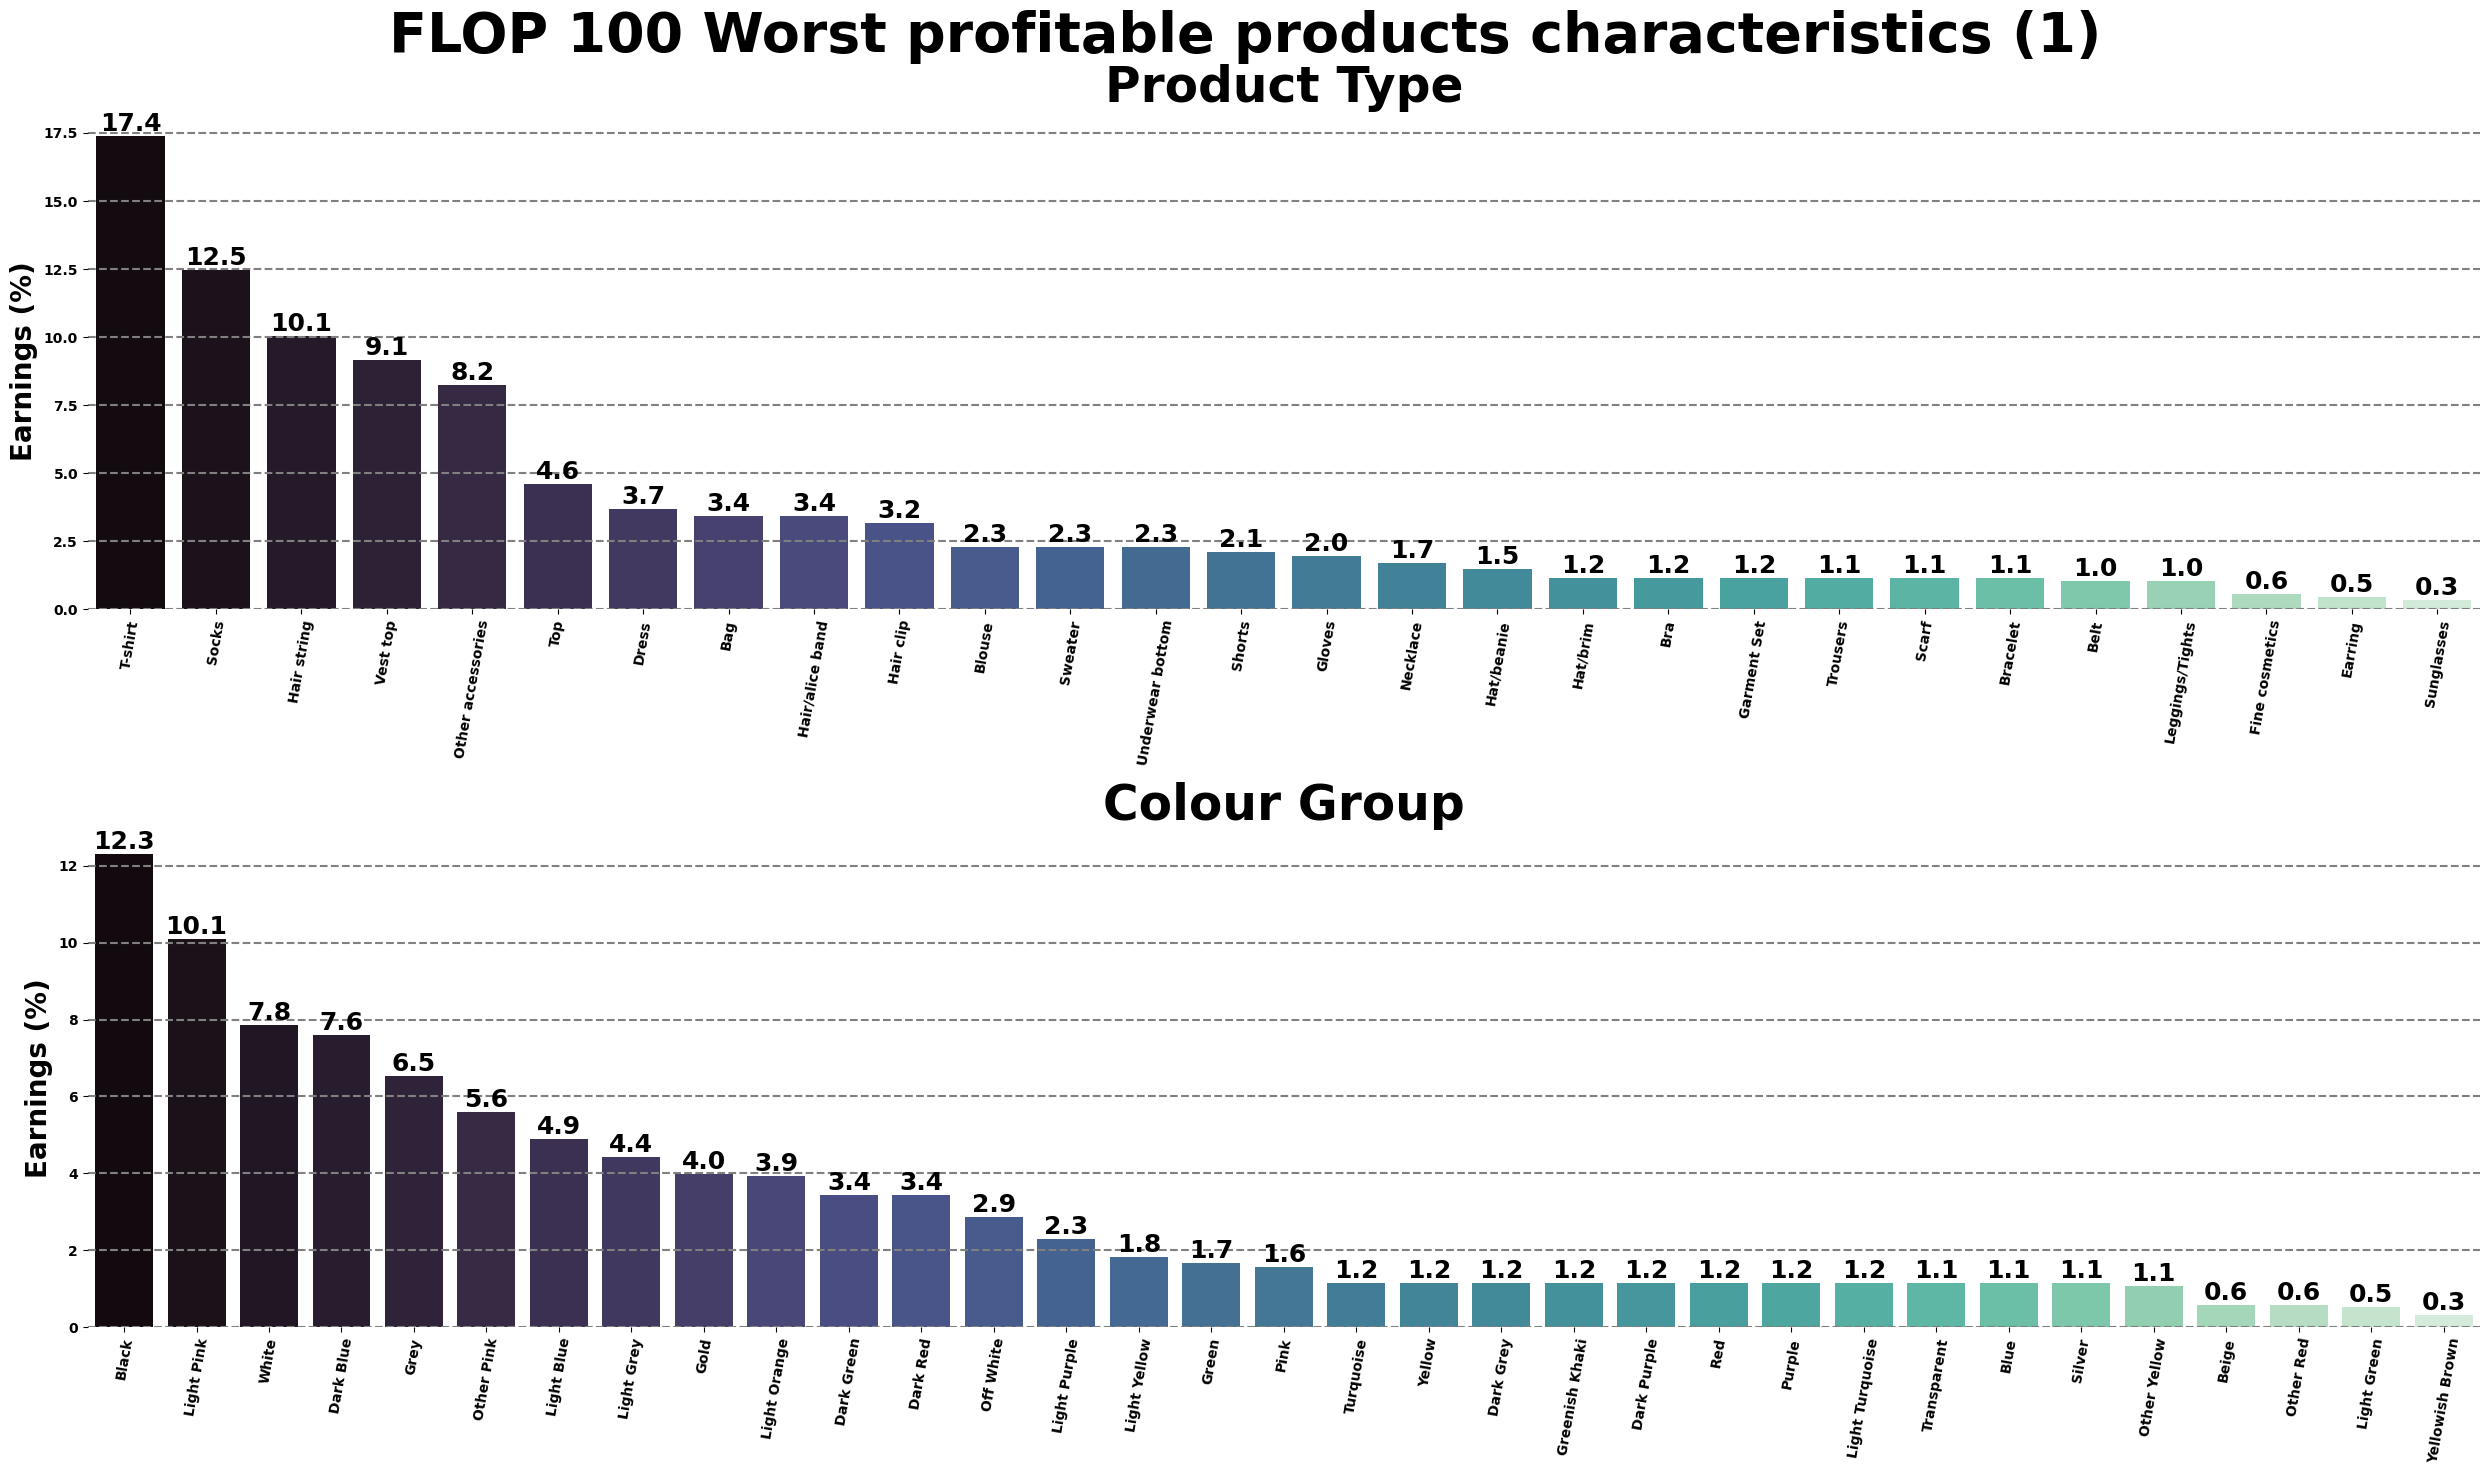

In [95]:
fig, ax = plt.subplots(2,1, figsize=(25,15))
plt.suptitle("FLOP 100 Worst profitable products characteristics (1)", fontsize=40 ,fontweight="bold")

no=100

g = sns.barplot(x="product_type_name", y="earning(%)", data=worst_100_price_details.iloc[:no].groupby("product_type_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', fontsize=18)
ax[0].grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
ax[0].set_xlabel("")
ax[0].set_ylabel("Earnings (%)", size=20,fontweight="bold")
ax[0].set_xticklabels(g.get_xticklabels(), rotation=80)
ax[0].set_title("Product Type", size=35,fontweight="bold")

g = sns.barplot(x="colour_group_name", y="earning(%)", data=worst_100_price_details.iloc[:no].groupby("colour_group_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[1],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', fontsize=18)
ax[1].set_ylabel("Earnings (%)", size=20,fontweight="bold")
ax[1].set_xlabel("")
ax[1].set_xticklabels(g.get_xticklabels(), rotation=80)
ax[1].set_title("Colour Group", size=35,fontweight="bold")
ax[1].grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)


fig.tight_layout()

plt.show() 

Insights: 
- 17.4% of them are t shirts
- 12.5% are socks
- There are quite a lot of accessories like hair bands, clips etc..

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2834292273.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="index_name", x="earning(%)", data=worst_100_price_details.iloc[:no].groupby("index_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2834292273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y="index_name", x="earning(%)", data=worst_100_price_details.iloc[:no].groupby("index_name")["earning"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2834292273.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  g = sns.barplot(y="product_group_name", x="earning(%)", data=worst_100_price_details.iloc[:no].groupby("product_group_name")["earning"].sum() \
C:\Users

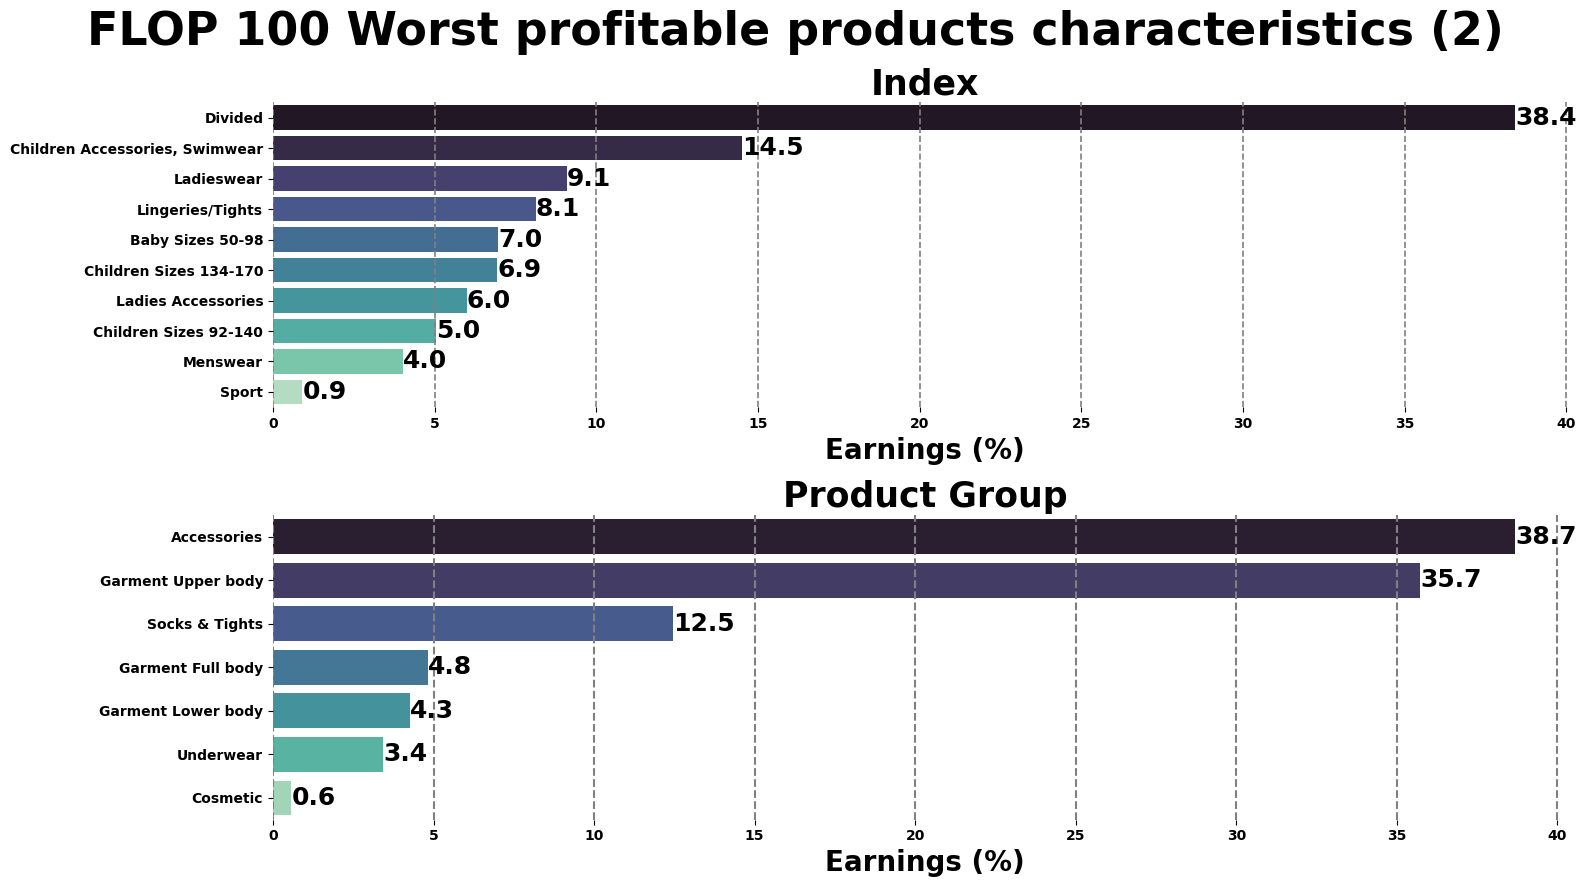

In [96]:
fig, ax = plt.subplots(2,1, figsize=(16,9))
plt.suptitle("FLOP 100 Worst profitable products characteristics (2)", fontsize=33 ,fontweight="bold")

no=100

g = sns.barplot(y="index_name", x="earning(%)", data=worst_100_price_details.iloc[:no].groupby("index_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[0],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', fontsize=18)
ax[0].set_ylabel("")
ax[0].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[0].set_title("Index",size=25,fontweight="bold")
ax[0].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.2)
             
g = sns.barplot(y="product_group_name", x="earning(%)", data=worst_100_price_details.iloc[:no].groupby("product_group_name")["earning"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index().sort_values(by="earning(%)", ascending=False), \
            ax=ax[1],palette="mako", ci=False)
for container in g.containers:
    g.bar_label(container, fmt='%.1f', fontsize=18)
ax[1].set_ylabel("")
ax[1].set_xlabel("Earnings (%)", size=20,fontweight="bold")
ax[1].set_title("Product Group", size=25,fontweight="bold")
ax[1].grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)
             
plt.tight_layout()
             
plt.show()

Insights:
- 38.7% of these only sonce once products are accessories
- Around 35% of these products are for children of babies

# Customer Analayis

In the following, we will start an analysis on the customers to find interesting insights and understand which customers are responsible for msot purchases.

In [97]:
df_t.head()

,customer_id,article_id,price
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932


In order to perform the analysis, we first decide to  create a new dataframe that will include, for each row, an unique customer_id, the total purchased quantity by that customer and the ernings generated by the company by the purchases of that customer.

First, we crate a dataframe which will include the unique customer ids and the earnings generated by theirs purchases.

In [98]:
df_cust_prices = df_t[["customer_id", "price"]].groupby("customer_id").sum()

In [99]:
df_cust_prices.head()

,price
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.648983
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2.601932
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.704780
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.060983
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.469695


Second, we create a dataframe that will include the unique customer ids and their total purchased quantity of products.

In [100]:
df_cust_qty = df_t[["customer_id", "article_id"]].groupby("customer_id").count()

In [101]:
df_cust_qty.head()

,article_id
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,21
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,86
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,13


Then, we join these two dataframe to a new one "cust_qty_price", which will include the unique customer ids, their purchased quantity and the earnings generated by the company by their purchases.

In [102]:
cust_qty_price = pd.merge(df_cust_prices, df_cust_qty, on='customer_id', how='inner')

In [103]:
cust_qty_price.head()

,price,article_id
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.648983,21
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2.601932,86
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.704780,18
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.060983,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.469695,13


Finally we can join this new dataframe to the Customer dataframe df_c, so that we can add some informations about the customer on the newly defined cust_qty_price dataframe.

In [104]:
df_c.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [105]:
cust_details = pd.merge(cust_qty_price, df_c.drop("postal_code", axis=1), on='customer_id', how='inner')

In [106]:
cust_details.head()

,customer_id,price,article_id,FN,Active,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.648983,21,NaN,NaN,ACTIVE,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2.601932,86,NaN,NaN,ACTIVE,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.704780,18,NaN,NaN,ACTIVE,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,2,NaN,NaN,ACTIVE,NONE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.469695,13,1.0,1.0,ACTIVE,Regularly,52.0


In [107]:
print(f"In total there are {len(cust_details)} different customers")

In total there are 1362281 different customers


# Purchased Quantity by Customer Analysis

Now we will analyze the purchased quantity by the customers.

In [108]:
cust_details.article_id.describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: article_id, dtype: float64

By calling the "describe" method on the "article_id" column, we can observe that:
- The minimum purchased quantity by a single customer is 1
- 25% of customers Purchased 3 or less items
- 50% of customers Purchased 9 or less items
- 75% of customers Purchased 27 or less items
- The maximum purchased quantity by a single customer is 1895 products

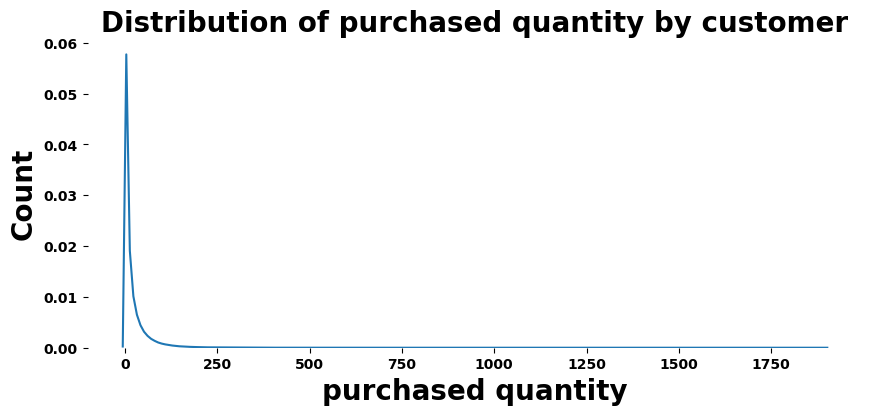

In [109]:
plt.figure(figsize=(10,4))
plt.title("Distribution of purchased quantity by customer", fontweight="bold", size=20)
sns.kdeplot(cust_details["article_id"])
plt.xlabel("purchased quantity",fontweight="bold", size=20)
plt.ylabel("Count",fontweight="bold", size=20)
plt.show()

Indeed, the distribution of this variable is highly skewed.

Next, we will analyze the age and other provided features of the customer to better find insights on the customers and their purchase behaviour.

# Purchase Behaviors according to Age

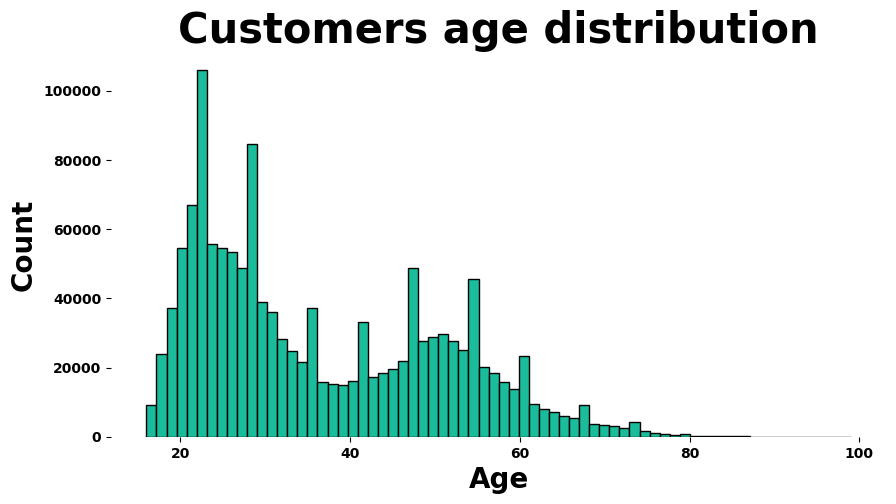

In [110]:
plt.figure(figsize=(10,5))
plt.title("Customers age distribution", fontweight="bold", size=30)
plt.hist(cust_details["age"], bins=70, edgecolor="black", color="#1ABC9C")
plt.xlabel("Age",fontweight="bold", size=20)
plt.ylabel("Count",fontweight="bold", size=20)
plt.show()

**The distribution of the age feature is bivariate. In order to create more effective plots, we will create a categorical column for age which divides the ages in age groups.**

# Q5 - Which age group purchase more articles?

In [111]:
cust_details['age_groups'] = pd.cut(cust_details['age'], bins=[16, 20, 30, 40,50, 60, 70, float('Inf')], labels=['16-20', '20-30','30-40','40-50','50-60','60-70' , '70+'])

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\1908619377.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sns.barplot(x="age_groups", y="Purchased Quantity(%)", data=cust_details.groupby("age_groups")["article_id"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\1908619377.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="age_groups", y="Purchased Quantity(%)", data=cust_details.groupby("age_groups")["article_id"].sum() \


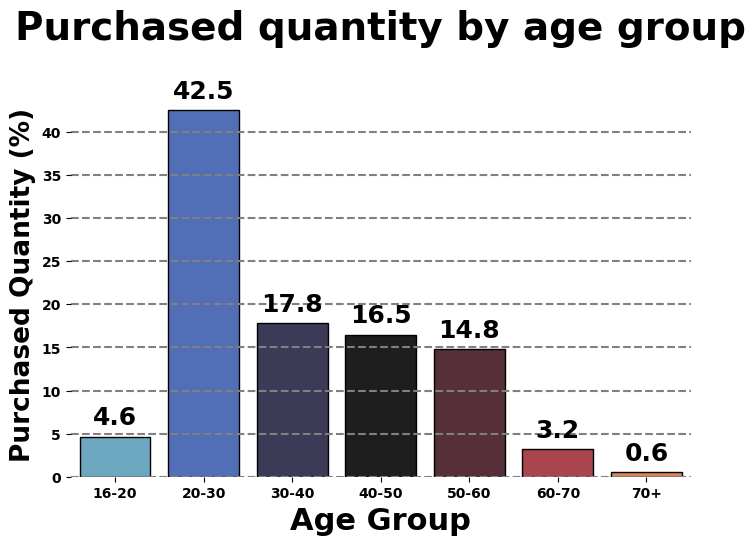

In [112]:
plt.figure(figsize=(8,5))
plt.title("Purchased quantity by age group\n", fontweight="bold", size=28)
g = sns.barplot(x="age_groups", y="Purchased Quantity(%)", data=cust_details.groupby("age_groups")["article_id"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('Purchased Quantity(%)').reset_index(), palette="icefire", edgecolor="black")
plt.xlabel("Age Group",fontweight="bold", size=22)
plt.ylabel("Purchased Quantity (%)",fontweight="bold", size=19)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=18, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

Insights:
- Customers in the range 20-30 are responsible for more than 42% of the total purchased products.
- Customers in the range 16-20. 60-70 and 70+ are responsible for the 8% of the total purchased products
- Customers in the range 30-40, 40-50 and 50-60 are responsible for 16% of purchased quantity each.

After analyzing the purchases quantity, it could be interesting to analyze the earnings provided to the company by each customer.

# Q6 - Which age group generates more earnings for the company?

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2928386704.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sns.barplot(x="age_groups", y="earning(%)", data=cust_details.groupby("age_groups")["price"].sum() \
C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2928386704.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="age_groups", y="earning(%)", data=cust_details.groupby("age_groups")["price"].sum() \


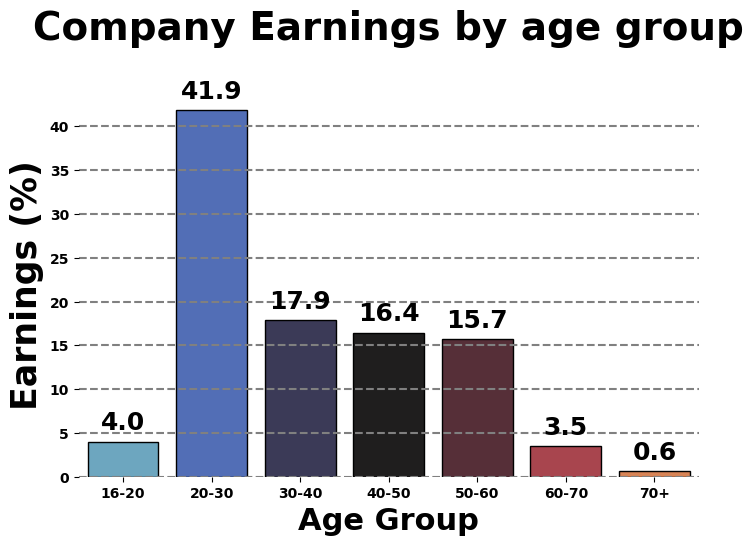

In [113]:
plt.figure(figsize=(8,5))
plt.title("Company Earnings by age group\n", fontweight="bold", size=28)
g = sns.barplot(x="age_groups", y="earning(%)", data=cust_details.groupby("age_groups")["price"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index(), palette="icefire",edgecolor="black")
plt.xlabel("Age Group",fontweight="bold", size=22)
plt.ylabel("Earnings (%)",fontweight="bold", size=25)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=18, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()


**Indeed a very similar situation to the purchases quantity can be found in the earnings analysis, since customers who buys more, on average leads to higher earnings for the company. <br>
The age group 20-30 is by far responsible for the highest earnings for the company (41.9% of total earnings).**

# Q7 - Do active customers on the fashion news purchase more articles?

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3606145360.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="fashion_news_frequency", y="Purchased Quantity(%)", data=cust_details.groupby("fashion_news_frequency")["article_id"].sum() \


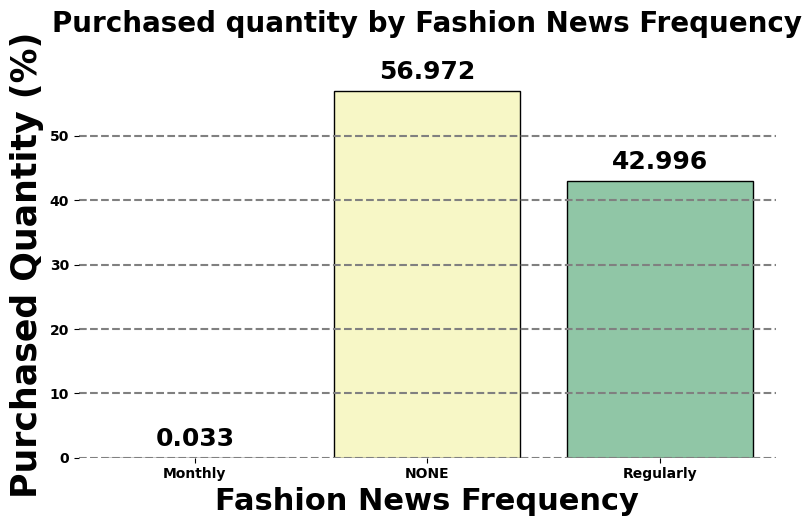

In [114]:
plt.figure(figsize=(9,5))
plt.title("Purchased quantity by Fashion News Frequency\n", fontweight="bold", size=20)
g = sns.barplot(x="fashion_news_frequency", y="Purchased Quantity(%)", data=cust_details.groupby("fashion_news_frequency")["article_id"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('Purchased Quantity(%)').reset_index(), palette="Spectral", edgecolor="black")
plt.xlabel("Fashion News Frequency",fontweight="bold", size=22)
plt.ylabel("Purchased Quantity (%)",fontweight="bold", size=25)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.3f', fontsize=18, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

**Active customers on the fashion news are responsible for 43% of the total purchases, while the remaining 57% of purchased quantity comes from customer not registed in the fashion news.** <br>
The other 2 categories "Monthly" and "None" can be ignored and won't be considered for the further analysis.

So then it could be interesting to check the fashion news frequency by age group, to find more useful insights,

In [115]:
x, y = 'age_groups', 'fashion_news_frequency'
df_age_news = cust_details.groupby(x)[y].value_counts(normalize=True)
df_age_news = df_age_news.mul(100)
df_age_news = df_age_news.rename('percent(%)').reset_index()
df_age_news = df_age_news[df_age_news["fashion_news_frequency"].isin(["Regularly","NONE"])]

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2516484474.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_age_news = cust_details.groupby(x)[y].value_counts(normalize=True)


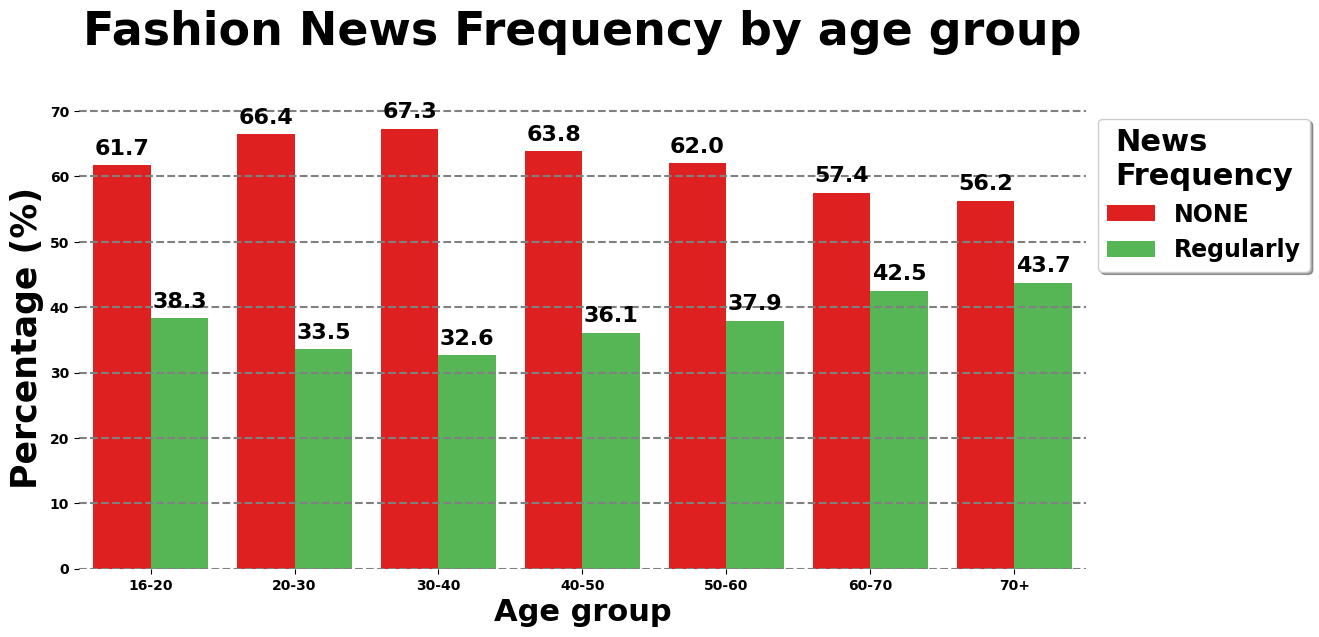

In [116]:
palette1 = {"Regularly":'#46C646', "NONE":'#FF0000'}

plt.figure(figsize=(13,6))
plt.title("Fashion News Frequency by age group\n",fontweight="bold", size=33)
g=sns.barplot(x="age_groups", y="percent(%)",data=df_age_news, hue="fashion_news_frequency", palette=palette1)
plt.xlabel("Age group",fontweight="bold", size=22)
plt.ylabel("Percentage (%)",fontweight="bold", size=25)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=16, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.legend(title='News\nFrequency',bbox_to_anchor=(1.0, 1.0), ncol=1, fancybox=True, shadow=True, fontsize=17,title_fontsize=22)
plt.show()

We can see that **customers in the range 20-30 and 30-40 have the lowest percentage of fashion news frequency, while being the groups which buy the most**.<br>
Moreover, **the frequency of customer that regulary check fashion news starts increasing from the range 40-50, with a peak value of 43.7% of regular/active users for customers in the range 70+ years old**. This means that **checking fashion news seems to be more effective for older customers, who still represent a small percentage of total sold products, while younger customers do not need to check the news to buy new products**. <br>
**It could be effective for the company to invite younger customers (range 20-40) to check the news more frequently in order to increase the sold items.**

# Q8 - Does the club member status influence the purchased quantity?

In [117]:
cust_details["club_member_status"].value_counts(normalize=True)

club_member_status
ACTIVE        0.931395
PRE-CREATE    0.068261
LEFT CLUB     0.000344
Name: proportion, dtype: float64

We can see that:
- More than 93% of the customers belong to the ACTIVE category
- 6.8% of the customers belong to the PRE-CREATE cateory
- 0.3% of the customers belong to the LEFT CLUB category

**This shows a very high imbalance among the classes: if we consider the sum of purchased products per each category, this will likely show that the most part of Purchased products belongs to the ACTIVE members.**

In [118]:
cust_details.groupby("club_member_status")["article_id"].sum()

club_member_status
ACTIVE        31057401
LEFT CLUB         8539
PRE-CREATE      660219
Name: article_id, dtype: int64

**Indeed, more customers in a group leads to higher purchases. For this reason, it is more wise to consider a mean Purchased quantity instead of a sum:**

In [119]:
print("The average quantity of purchased products by the customers is {:.0f} products ".format(cust_details["article_id"].mean()))

The average quantity of purchased products by the customers is 23 products 


In [120]:
print("The average quantity of purchased products by the ACTIVE customers is {:.0f} products ".format(cust_details.groupby("club_member_status")["article_id"].mean()["ACTIVE"]))
print("The average quantity of purchased products by the LEFT-CLUB customers is {:.0f} products ".format(cust_details.groupby("club_member_status")["article_id"].mean()["LEFT CLUB"]))
print("The average quantity of purchased products by the PRE-CREATE customers is {:.0f} products ".format(cust_details.groupby("club_member_status")["article_id"].mean()["PRE-CREATE"]))

The average quantity of purchased products by the ACTIVE customers is 25 products 
The average quantity of purchased products by the LEFT-CLUB customers is 18 products 
The average quantity of purchased products by the PRE-CREATE customers is 7 products 


By considering the mean, we can see a very different situation, which will be shown as percentages in the following plot:

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\3046494057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="club_member_status", y="article_id", data=cust_details.groupby("club_member_status")["article_id"].mean().astype(int).reset_index(), palette="viridis", edgecolor="black")


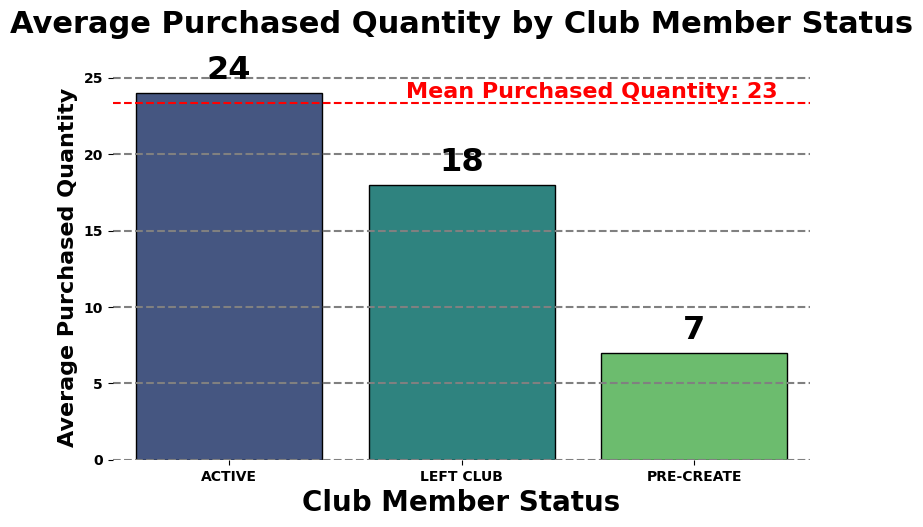

In [121]:
plt.figure(figsize=(9,5))
plt.title("Average Purchased Quantity by Club Member Status\n", fontweight="bold", size=22)
g = sns.barplot(x="club_member_status", y="article_id", data=cust_details.groupby("club_member_status")["article_id"].mean().astype(int).reset_index(), palette="viridis", edgecolor="black")
plt.axhline(y = cust_details["article_id"].mean(), color = 'r', linestyle = '--')
plt.text(0.76, 23.7, 'Mean Purchased Quantity: {:.0f}'.format(cust_details["article_id"].mean()), size=16, color="red",fontweight="bold")
plt.xlabel("Club Member Status",fontweight="bold", size=20)
plt.ylabel("Average Purchased Quantity",fontweight="bold", size=16)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.0f', fontsize=23, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

**This plots shows that the average purchased quantity differs a lot among the categories**. <br>
In particular, **customers belonging to the ACTIVE clubs, purchase more products than other categories, while those in the "pre-create" category purchaes on average less than a third of third of active customers**.

Finally, since the distribution of the purchased quantity is heavily right skewed, it could be interesting to check out also the median purhcased quantity.

C:\Users\vietd\AppData\Local\Temp\ipykernel_6844\2935518540.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="club_member_status", y="article_id", data=cust_details.groupby("club_member_status")["article_id"].median().reset_index(), palette="viridis", edgecolor="black")


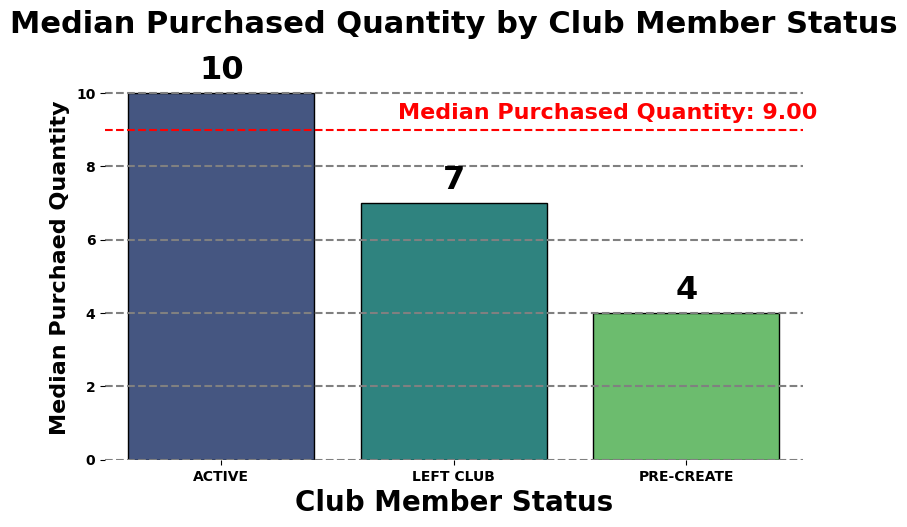

In [122]:
plt.figure(figsize=(9,5))
plt.title("Median Purchased Quantity by Club Member Status\n", fontweight="bold", size=22)
g = sns.barplot(x="club_member_status", y="article_id", data=cust_details.groupby("club_member_status")["article_id"].median().reset_index(), palette="viridis", edgecolor="black")
plt.axhline(y = cust_details["article_id"].median(), color = 'r', linestyle = '--')
plt.text(0.76, 9.3, 'Median Purchased Quantity: {:.2f}'.format(cust_details["article_id"].median()), size=16, color="red",fontweight="bold")
plt.xlabel("Club Member Status",fontweight="bold", size=20)
plt.ylabel("Median Purchaed Quantity",fontweight="bold", size=16)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.0f', fontsize=23, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

Indeed, even if the Median is quite different for the Mean due to high skeweness of the data, a very similar situation situation to the mean purchases quantity can be observed, where ACTIVE customers buys more product on average.